I have data related to city traffic that i generate through a simulation and i need implement a algorithm that will generate predictions and recommendations based upon that data. This data contain number of vehicles, position of vehicles, speed of vehicles; the position of vehicles are time based.
The prediction purpose is to predict how much congestion will be at whole modeled area
Then recommendations can be generated from that provided dataset
E.g. traffic congestion remains high at lane 12, so recommendations can be; number of lanes should be increased, maintenance of road should be regular.
I also need to integrate this script with my web portal which is developed on react.
In simpler terms, you need to:
1. Provide a script that predicts congestion rate using any model using the provided data. the predictions are result of congestion rate that you have to calculate using all the inputs of the data. You have to define a formula for congestion using all the input variables, which you thing that have the best effect on congestion rate.
2. Make recommendation on it on the predicted values. You can divide the data with respect "timestamp" and then provide recommendations the most congested area. you can pre define some recommendations, for example, traffic congestion remains high at lane 12, so recommendations can be; number of lanes should be increased, maintenance of road should be regular and show when congestion rates are high. You divide the whole data into timestamps and then you can say that during a particular timestamp, congestion rate was high/low/medium.
3. The predictions and recommendation model needs be integrated with my web portal
4. Provide me just a little feedback, so that if there is any confusion in our minds we can clear at that very moment. I cannot afford to revise things after 19th.

### XML to Datafarme

In [1]:
# import pandas as pd 
# import xml.etree.ElementTree as etree
# tree = etree.parse("ISL.fcd_geo.xml")
# root = tree.getroot()
# columns = ["timestep","id","x","y","angle","type","speed","pos","lane","slope"]
# datatframe = pd.DataFrame(columns = columns)
# for node in root:
#     for subnode in node:
#         timestep = node.attrib.get("time")
#         id_ = subnode.attrib.get("id")
#         x = subnode.attrib.get("x")
#         y = subnode.attrib.get("y")
#         angle = subnode.attrib.get("angle")
#         type_ = subnode.attrib.get("type")
#         speed = subnode.attrib.get("speed")
#         pos = subnode.attrib.get("pos")
#         lane = subnode.attrib.get("lane")
#         slope = subnode.attrib.get("slope")
#         datatframe = datatframe.append(pd.Series([timestep,id_, x, y,angle,type_,speed,pos,lane,slope], index = columns), ignore_index = True)
# datatframe.to_csv('main_data.csv')

you can just read it derictly (after converting)

In [182]:
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [183]:
## Read area lables
## in this cell we will read area names for each lane then we will store them in a dictionary.
import glob
import os

streets = ['F6','F7','F8','F10','F11','G6','G7','G8','G9','G10','G11']
dictionary = {street: [] for street in streets} #key:street_id, value: list of lanes

text_files_list = glob.glob("./Streets IDs/*.txt")
for file in text_files_list:
    street_name = find_between(file,'IDs/','.txt')
    with open(file) as f:
        for line in f:
            lane = line[5:].rstrip()
            dictionary[street_name].append(lane)

### Data preparation

After we convert the data to a datafarme now we will prepare the data and compute the target label(congestion or no congestion)

In [184]:
#we read the data converted
import pandas as pd
data = pd.read_csv('main_data.csv')
data = data.drop('Unnamed: 0',axis=1)
#Then we add a new column called speed_AVG that gives the speed average for each lane.
data = data.join(data.groupby('lane')['speed'].sum(), on='lane', rsuffix='_AVG')

In [185]:
data.shape

(300907, 11)

In [186]:
data.head()

,timestep,id,x,y,angle,type,speed,pos,lane,slope,speed_AVG
0,14400.0,h26925c1:1,73.079136,33.711080,57.504310,default,0.00,16.17,23357319#1_0,0.0,0.000
1,18000.0,h25899c1:1,73.082447,33.708460,57.852308,default,0.00,44.36,-23489494#0_0,0.0,2.499
2,18000.0,h26925c1:1,73.079536,33.711190,149.642244,default,13.89,4.69,-23357328#3_0,0.0,133.431
3,18000.0,h27385c1:1,73.086303,33.709846,150.148767,default,0.00,21.65,23367669_0,0.0,166.680
4,18000.0,h2926c1:1,73.077335,33.732284,239.009070,default,0.00,153.53,22292736#1_0,0.0,27.780


we will base on avg_speed to compute the build the label(congestion or not). To explain more assum we have a congestion so all the vehicules will have 0 speed so the avg will be 0. thus,we have a congestion then we will add label(1) to all vehicules in this lane.

In [187]:
NewMax = 100
NewMin = 0
OldMin = data['speed_AVG'].min()
OldMax = data['speed_AVG'].max()
OldRange = (OldMax - OldMin)  
NewRange = (NewMax - NewMin)
data['congestion'] = [(((OldValue - OldMin) * NewRange) / OldRange) + NewMin for OldValue in data['speed_AVG']]

In [203]:
# # for street, lane_names in dictionary.items():
# #     print(lane_names)
# # Next lets add streets ID
# streets = []
# for lane in data['lane']:
#     for street, lane_names in dictionary.items():
#         if lane in lane_names:
#             streets.append(street)
# data['streets'] = streets

In [136]:
from sklearn import preprocessing
# Machine learning models needs 
# ENcode id colmun
le_id = preprocessing.LabelEncoder()
le_id.fit(data['id'])
id_encode = le_id.transform(data['id'])
data['id'] = id_encode
#encode lane column
le_lane = preprocessing.LabelEncoder()
le_lane.fit(data['lane'])
lane_encode = le_lane.transform(data['lane'])
data['lane'] = lane_encode

In [137]:
data.head()

,timestep,id,x,y,angle,type,speed,pos,lane,slope,speed_AVG,congestion
0,14400.0,14708,73.079136,33.711080,57.504310,default,0.00,16.17,7385,0.0,0.000,0.000000
1,18000.0,13838,73.082447,33.708460,57.852308,default,0.00,44.36,2508,0.0,2.499,0.281115
2,18000.0,14708,73.079536,33.711190,149.642244,default,13.89,4.69,2257,0.0,133.431,15.009787
3,18000.0,15124,73.086303,33.709846,150.148767,default,0.00,21.65,7449,0.0,166.680,18.750000
4,18000.0,16310,73.077335,33.732284,239.009070,default,0.00,153.53,5274,0.0,27.780,3.125000


**We have now the congestion is a percentage between 0-100 represnet the congestion**

now we will remove all unecessary features.

In [138]:
new_data = data.drop(['type','speed','speed_AVG','slope'],axis=1)

In [139]:
new_data.head()

,timestep,id,x,y,angle,pos,lane,congestion
0,14400.0,14708,73.079136,33.711080,57.504310,16.17,7385,0.000000
1,18000.0,13838,73.082447,33.708460,57.852308,44.36,2508,0.281115
2,18000.0,14708,73.079536,33.711190,149.642244,4.69,2257,15.009787
3,18000.0,15124,73.086303,33.709846,150.148767,21.65,7449,18.750000
4,18000.0,16310,73.077335,33.732284,239.009070,153.53,5274,3.125000


In [140]:
X = new_data.drop('congestion',axis=1)
y = new_data['congestion']

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor()

In [142]:
y_pred = clf.predict(X_test)

In [143]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

2.3627307052709337

### Predictions and recommendations

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

In [144]:
Perdiction_dataframe = pd.DataFrame(columns = new_data.columns,data=X_test)
Perdiction_dataframe['congestion'] = y_pred 

In [145]:
#we should decoude id and lane columns
Perdiction_dataframe['id'] = le_id.inverse_transform(Perdiction_dataframe['id'])
Perdiction_dataframe['lane'] = le_lane.inverse_transform(Perdiction_dataframe['lane'])

In [146]:
Perdiction_dataframe.head()

,timestep,id,x,y,angle,pos,lane,congestion
262074,75600.0,h46502c1:1,73.038747,33.694304,238.770681,35.43,-604353956#1_0,0.000000
26334,36000.0,h41156c1:1,73.049546,33.689749,149.547039,20.20,23312877#2_0,0.651509
219364,72000.0,carIn78219:3,73.037686,33.704913,328.132198,41.69,17399990#2_0,21.662530
40601,39600.0,h38606c1:1,73.045219,33.694017,27.304101,1.48,20337021#2_0,18.855563
56616,43200.0,h35623c1:1,73.069515,33.698347,59.010659,5.00,307558360#5_0,24.767031


From the plots we can get some recommendation. we know that the congestion value ranges from 0 to 100. so we can choose a treshold .for example lets detect all **lanes** with congestion above 70% 

In [193]:
data_test = Perdiction_dataframe[Perdiction_dataframe['congestion']>70]

<AxesSubplot:xlabel='lane', ylabel='congestion'>

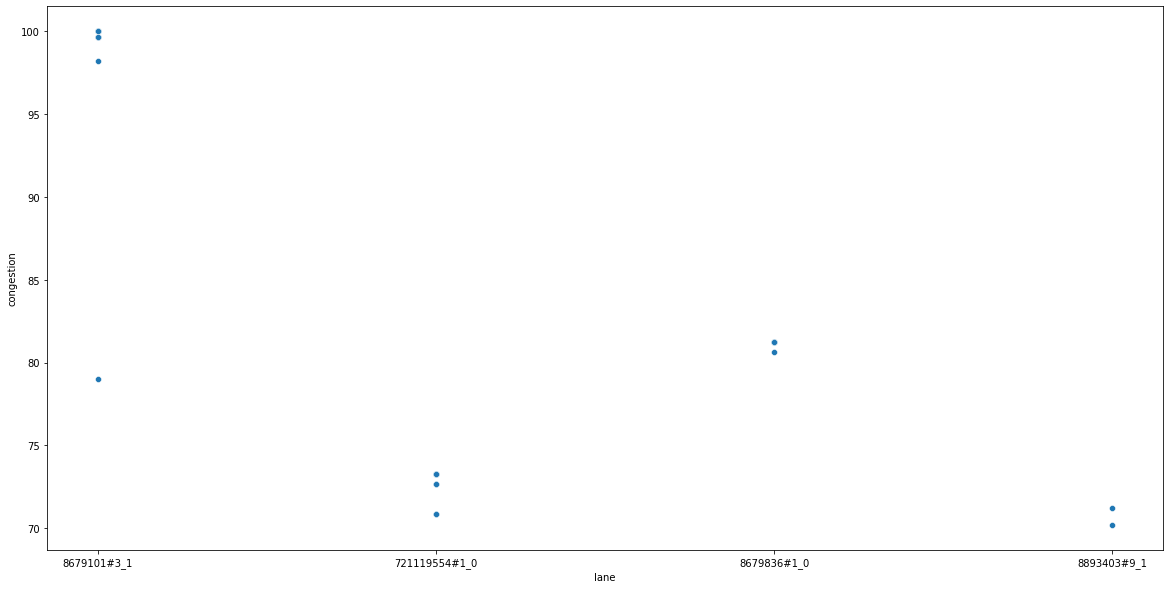

In [194]:
plt.figure(figsize=(20,10))
sns.scatterplot(data= data_test,x='lane', y='congestion')#, color='DarkBlue', label='Group 1');

Or we can do the same ,this time in relation with timestep

<AxesSubplot:xlabel='timestep', ylabel='congestion'>

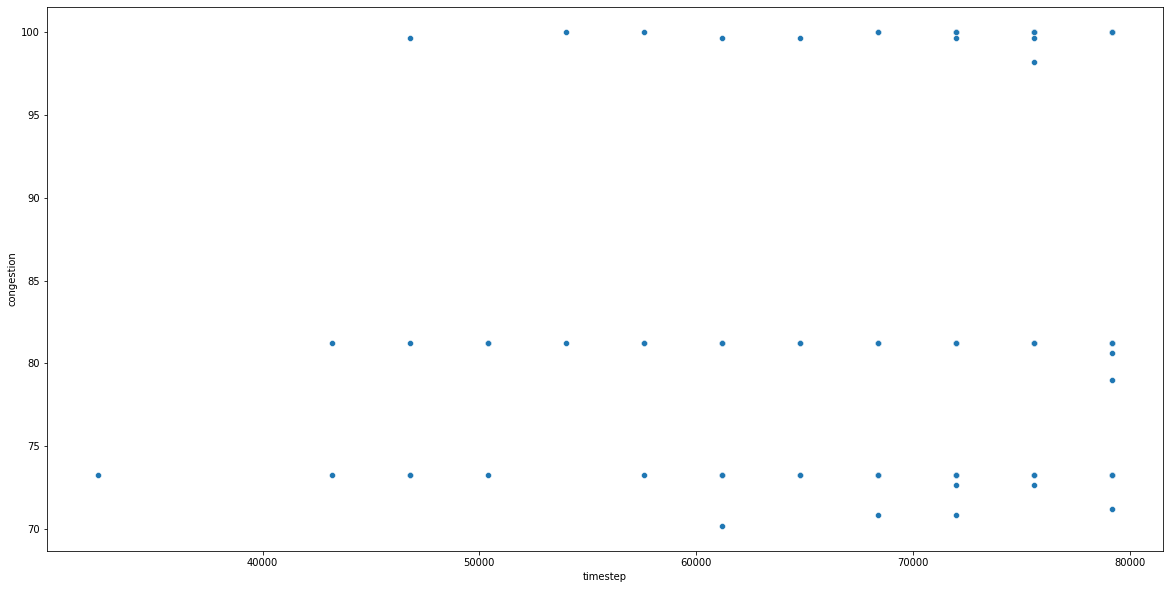

In [195]:
plt.figure(figsize=(20,10))
sns.scatterplot(data= data_test,x='timestep', y='congestion')#, color='DarkBlue', label='Group 1');

Or we can visualize the two variables(timestep and lane) with relation with congestion.

<AxesSubplot:xlabel='timestep', ylabel='congestion'>

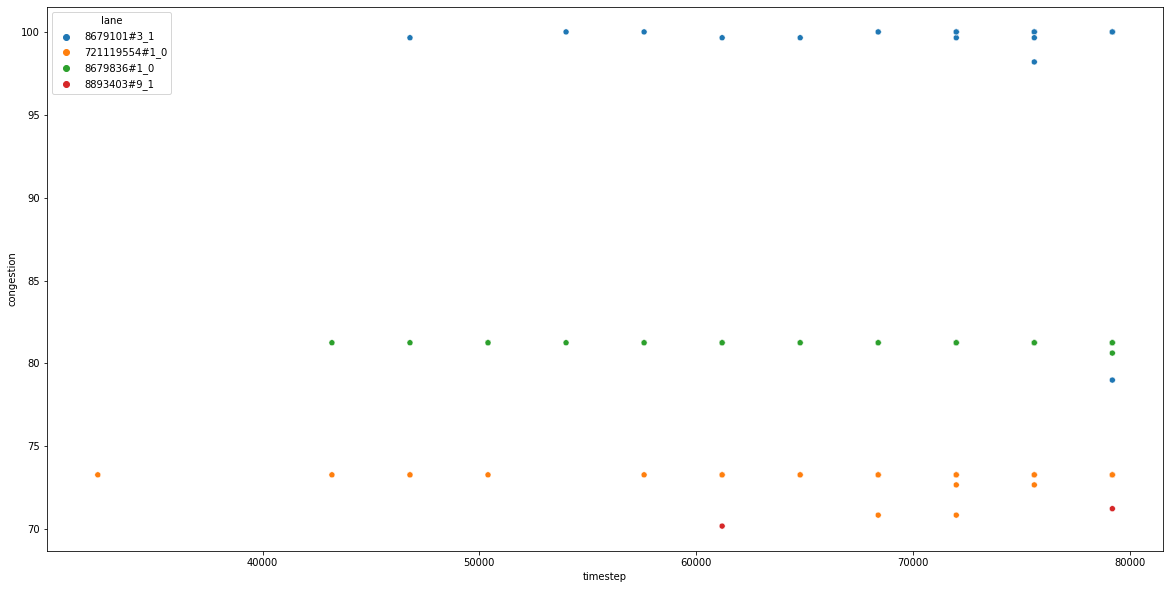

In [196]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=data_test, x="timestep", y="congestion", hue="lane")

By a notification message

In [200]:
data_test = Perdiction_dataframe[Perdiction_dataframe['congestion']==100]

In [202]:
print('the following lanes :\n \n {} \n have high congestion in the following timesteps:\n {} '.format(
set(list(data_test['lane'])),set(list(data_test['timestep']))))

the following lanes :
 
 {'8679101#3_1'} 
 have high congestion in the following timesteps:
 {72000.0, 79200.0, 57600.0, 68400.0, 75600.0, 54000.0} 
